In [67]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
# Load the datasets
customers_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagements_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_df = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [69]:
# data cleaning
# Convert date columns to datetime format
customers_df['join_date'] = pd.to_datetime(customers_df['join_date'])
customers_df['last_purchase_date'] = pd.to_datetime(customers_df['last_purchase_date'])
transactions_df['transaction_date'] = pd.to_datetime(transactions_df['transaction_date'])
marketing_df['campaign_date'] = pd.to_datetime(marketing_df['campaign_date'])

In [70]:
# Define the cutoff date
Research_date = pd.to_datetime('2024-05-31')

In [71]:
# Merging forms together
# Aggregate marketing responses
marketing_agg = marketing_df.groupby('customer_id')['response'].value_counts().unstack(fill_value=0).reset_index()
marketing_agg.columns = ['customer_id', 'no_response', 'yes_response']


In [72]:
# Aggregate transaction data
transactions_agg = transactions_df.groupby('customer_id').agg(
    total_transaction_amount=pd.NamedAgg(column='transaction_amount', aggfunc='sum'),
    number_of_transactions=pd.NamedAgg(column='transaction_id', aggfunc='count')
).reset_index()

# Merge all dataframes
merged_df = customers_df.merge(engagements_df, on='customer_id', how='left') \
                        .merge(marketing_agg, on='customer_id', how='left') \
                        .merge(transactions_agg, on='customer_id', how='left')

In [73]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,total_transaction_amount,number_of_transactions
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,1,3509.48,6
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,2,2,6081.32,9
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,1,1,1454.87,6
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,3,1,7874.68,20
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,4,0,15524.55,24


In [75]:
# Check for missing values in each column
missing_values = merged_df.isnull().sum()

# Display the missing values
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
customer_id                    0
join_date                      0
last_purchase_date             0
age                         1009
gender                       533
location                       0
number_of_site_visits          0
number_of_emails_opened        0
number_of_clicks               0
no_response                    0
yes_response                   0
total_transaction_amount       0
number_of_transactions         0
dtype: int64


In [77]:
# Inpute missing values in gender
merged_df['gender'] = merged_df['gender'].fillna('Unknown')

In [76]:
# Impute missing age with KNNImputer
from sklearn.impute import KNNImputer
# Prepare data for age KNN imputation
# Encode location and gender
from sklearn.preprocessing import LabelEncoder
le_gender = LabelEncoder()
merged_df['gender_encoded'] = le_gender.fit_transform(merged_df['gender'])
le_location = LabelEncoder()
merged_df['location_encoded'] = le_location.fit_transform(merged_df['location'])





In [78]:
# Prepare data for age KNN imputation
# Convert date columns to numeric
merged_df['join_date_numeric'] = merged_df['join_date'].astype('int64') // 10**9
merged_df['last_purchase_date_numeric'] = merged_df['last_purchase_date'].astype('int64') // 10**9

In [79]:
# Perform KNN imputation
impute_cols = ['age', 'join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded']
impute_data = merged_df[impute_cols]
knn_imputer = KNNImputer(n_neighbors=5)
imputed_data = knn_imputer.fit_transform(impute_data)


In [80]:
# Assign imputed age values back to the dataframe
merged_df['age'] = imputed_data[:, 0]

# Drop intermediate columns
merged_df = merged_df.drop(columns=['join_date_numeric', 'last_purchase_date_numeric', 'gender_encoded', 'location_encoded'])

In [15]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,total_transaction_amount,number_of_transactions
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,1,3509.48,6
1,2,2021-09-08,2023-10-25,50.2,Male,Hillville,285,49,51,2,2,6081.32,9
2,3,2021-06-01,2022-11-27,47.2,Unknown,North Latoyatown,192,73,25,1,1,1454.87,6
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,3,1,7874.68,20
4,5,2022-01-24,2023-06-02,40.0,Male,East Matthewfort,161,2,7,4,0,15524.55,24


In [16]:
# Feture Engineering
# Calculate Recency, Frequency, Monetary, CLV_monthly and Tenure for each customer
# Define the cutoff date
Research_date = pd.to_datetime('2024-05-31')

# Recency: Months since the last purchase
merged_df['recency'] = (( merged_df['last_purchase_date'] - Research_date).dt.days/ 30).astype(int)

# Frequency: Number of transactions
merged_df['frequency'] = merged_df['number_of_transactions']

# CLV: Total amount spent
merged_df['clv'] = merged_df['total_transaction_amount']
# Tenure: Months since the first purchase
merged_df['tenure'] = ((Research_date - merged_df['join_date']).dt.days/ 30).astype(int)
merged_df['tenure'] = merged_df['tenure'].apply(lambda x: 1 if x == 0 else x)
# CLV_monthly: Total amount spent per month for each customer
merged_df['clv_monthly'] = merged_df['clv']/merged_df['tenure']


In [17]:
merged_df = merged_df.drop(columns=['total_transaction_amount', 'number_of_transactions']) 

In [18]:
merged_df.head()

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,recency,frequency,clv,tenure,clv_monthly
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,1,-2,6,3509.48,6,584.913333
1,2,2021-09-08,2023-10-25,50.2,Male,Hillville,285,49,51,2,2,-7,9,6081.32,33,184.282424
2,3,2021-06-01,2022-11-27,47.2,Unknown,North Latoyatown,192,73,25,1,1,-18,6,1454.87,36,40.413056
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,3,1,-21,20,7874.68,29,271.540690
4,5,2022-01-24,2023-06-02,40.0,Male,East Matthewfort,161,2,7,4,0,-12,24,15524.55,28,554.448214


In [19]:
# Fill any NaN values resulting from zero transactions or other calculations
merged_df['recency'] = merged_df['recency'].fillna(0)
merged_df['frequency'] = merged_df['frequency'].fillna(0)
merged_df['clv_monthly'] = merged_df['clv_monthly'].fillna(0)

In [20]:
# Calculate the cumulative contribution of each customer to the total monthly CLV
merged_df = merged_df.sort_values(by='clv_monthly', ascending=False)
merged_df['cumulative_clv'] = merged_df['clv_monthly'].cumsum()
total_clv = merged_df['clv_monthly'].sum()
merged_df['cumulative_clv_percentage'] = merged_df['cumulative_clv'] / total_clv


In [21]:
merged_df.head(2500)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,recency,frequency,clv,tenure,clv_monthly,cumulative_clv,cumulative_clv_percentage
7015,7016,2024-05-14,2024-05-28,45.0,Unknown,West Karifort,6,1,1,1,0,0,25,22364.72,1,22364.720000,2.236472e+04,0.002740
6632,6633,2024-05-25,2024-05-28,54.0,Male,Anthonymouth,1,1,1,3,0,0,25,21518.15,1,21518.150000,4.388287e+04,0.005376
7583,7584,2024-04-20,2024-05-12,24.0,Female,Elizabethton,1,1,1,1,1,0,25,21056.06,1,21056.060000,6.493893e+04,0.007956
8833,8834,2024-04-17,2024-04-22,40.0,Unknown,Georgehaven,1,1,1,1,0,-1,23,17721.61,1,17721.610000,8.266054e+04,0.010127
5825,5826,2024-05-20,2024-05-30,45.0,Male,Aprilport,4,1,1,1,3,0,25,17360.68,1,17360.680000,1.000212e+05,0.012254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,7425,2022-07-04,2022-10-05,44.0,Female,New Rickbury,23,5,4,1,2,-20,22,13843.30,23,601.882609,6.401149e+06,0.784217
1379,1380,2022-07-30,2022-08-27,25.0,Female,Williamburgh,8,1,1,1,2,-21,20,13240.87,22,601.857727,6.401751e+06,0.784291
3330,3331,2021-12-11,2023-06-15,47.6,Male,Lake Ritamouth,241,33,14,1,1,-11,25,18042.67,30,601.422333,6.402352e+06,0.784364
4241,4242,2022-10-17,2023-06-15,60.0,Female,Parkerberg,54,24,1,1,2,-11,20,11412.16,19,600.640000,6.402953e+06,0.784438


In [22]:
# as the analysis shows above, the upper quartile(first 25% highest) highest customers' CLV_monthly contribut about 80% of total
# so I set the value of upper quartile CLV_monthly as the identifier of High value customer and Low value customer
# Label customers based on their contribution to the total monthly CLV
merged_df['value_label'] = np.where(merged_df['clv_monthly'] >= 600.632, 'High-Value', 'Low-Value')

# Convert CLV_label to binary
merged_df['value_label'] = np.where(merged_df['value_label'] == 'High-Value', 1, 0)

# Drop intermediate columns
merged_df = merged_df.drop(columns=['cumulative_clv', 'cumulative_clv_percentage'])

In [23]:
merged_df.head(2500)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,yes_response,recency,frequency,clv,tenure,clv_monthly,value_label
7015,7016,2024-05-14,2024-05-28,45.0,Unknown,West Karifort,6,1,1,1,0,0,25,22364.72,1,22364.720000,1
6632,6633,2024-05-25,2024-05-28,54.0,Male,Anthonymouth,1,1,1,3,0,0,25,21518.15,1,21518.150000,1
7583,7584,2024-04-20,2024-05-12,24.0,Female,Elizabethton,1,1,1,1,1,0,25,21056.06,1,21056.060000,1
8833,8834,2024-04-17,2024-04-22,40.0,Unknown,Georgehaven,1,1,1,1,0,-1,23,17721.61,1,17721.610000,1
5825,5826,2024-05-20,2024-05-30,45.0,Male,Aprilport,4,1,1,1,3,0,25,17360.68,1,17360.680000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,7425,2022-07-04,2022-10-05,44.0,Female,New Rickbury,23,5,4,1,2,-20,22,13843.30,23,601.882609,1
1379,1380,2022-07-30,2022-08-27,25.0,Female,Williamburgh,8,1,1,1,2,-21,20,13240.87,22,601.857727,1
3330,3331,2021-12-11,2023-06-15,47.6,Male,Lake Ritamouth,241,33,14,1,1,-11,25,18042.67,30,601.422333,1
4241,4242,2022-10-17,2023-06-15,60.0,Female,Parkerberg,54,24,1,1,2,-11,20,11412.16,19,600.640000,1


In [24]:
# converting number_of_site_visits,	number_of_emails_opened, number_of_clicks and number of Yes answers into monthly amount

merged_df['site_visits_monthly'] = merged_df['number_of_site_visits'] / merged_df['tenure']
merged_df['emails_opened_monthly'] = merged_df['number_of_emails_opened'] / merged_df['tenure']
merged_df['clicks_monthly'] = merged_df['number_of_clicks'] / merged_df['tenure']
merged_df['yes_response_monthly'] = merged_df['yes_response'] / merged_df['tenure']


In [25]:
# Data exploration
# the highest 25% of customer contribute to about 80% of the CLV
merged_df.head(2500)

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,no_response,...,recency,frequency,clv,tenure,clv_monthly,value_label,site_visits_monthly,emails_opened_monthly,clicks_monthly,yes_response_monthly
7015,7016,2024-05-14,2024-05-28,45.0,Unknown,West Karifort,6,1,1,1,...,0,25,22364.72,1,22364.720000,1,6.000000,1.000000,1.000000,0.000000
6632,6633,2024-05-25,2024-05-28,54.0,Male,Anthonymouth,1,1,1,3,...,0,25,21518.15,1,21518.150000,1,1.000000,1.000000,1.000000,0.000000
7583,7584,2024-04-20,2024-05-12,24.0,Female,Elizabethton,1,1,1,1,...,0,25,21056.06,1,21056.060000,1,1.000000,1.000000,1.000000,1.000000
8833,8834,2024-04-17,2024-04-22,40.0,Unknown,Georgehaven,1,1,1,1,...,-1,23,17721.61,1,17721.610000,1,1.000000,1.000000,1.000000,0.000000
5825,5826,2024-05-20,2024-05-30,45.0,Male,Aprilport,4,1,1,1,...,0,25,17360.68,1,17360.680000,1,4.000000,1.000000,1.000000,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7424,7425,2022-07-04,2022-10-05,44.0,Female,New Rickbury,23,5,4,1,...,-20,22,13843.30,23,601.882609,1,1.000000,0.217391,0.173913,0.086957
1379,1380,2022-07-30,2022-08-27,25.0,Female,Williamburgh,8,1,1,1,...,-21,20,13240.87,22,601.857727,1,0.363636,0.045455,0.045455,0.090909
3330,3331,2021-12-11,2023-06-15,47.6,Male,Lake Ritamouth,241,33,14,1,...,-11,25,18042.67,30,601.422333,1,8.033333,1.100000,0.466667,0.033333
4241,4242,2022-10-17,2023-06-15,60.0,Female,Parkerberg,54,24,1,1,...,-11,20,11412.16,19,600.640000,1,2.842105,1.263158,0.052632,0.105263


In [26]:

# Check the percentage of 'High-valued customer' VS 'Low value customer'
Customer_type = merged_df['value_label'].value_counts(normalize=True)

# Print the class distribution
print(Customer_type)

value_label
0    0.75
1    0.25
Name: proportion, dtype: float64


C:\Users\think\AppData\Local\Temp\ipykernel_15476\998143371.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_clv_by_age_group = merged_df.groupby(age_groups)['clv_monthly'].mean().reset_index()


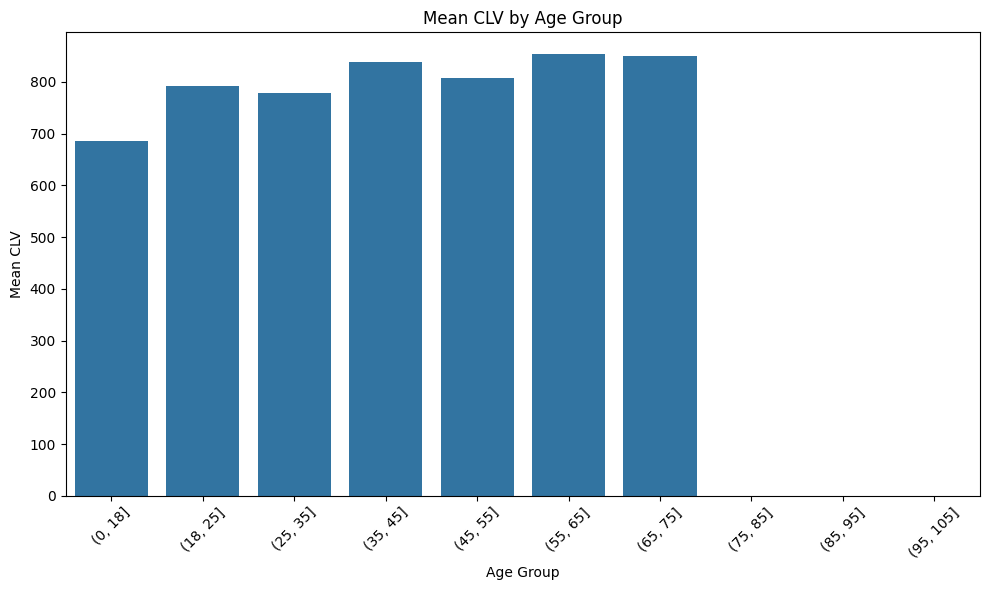

In [27]:
# Analyze relationship between age and CLV_monthly
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate mean CLV for different age groups
age_groups = pd.cut(merged_df['age'], bins=[0, 18, 25, 35, 45, 55, 65, 75, 85, 95, 105])
mean_clv_by_age_group = merged_df.groupby(age_groups)['clv_monthly'].mean().reset_index()

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_clv_by_age_group['age'], y=mean_clv_by_age_group['clv_monthly'])
plt.xlabel('Age Group')
plt.ylabel('Mean CLV')
plt.title('Mean CLV by Age Group')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

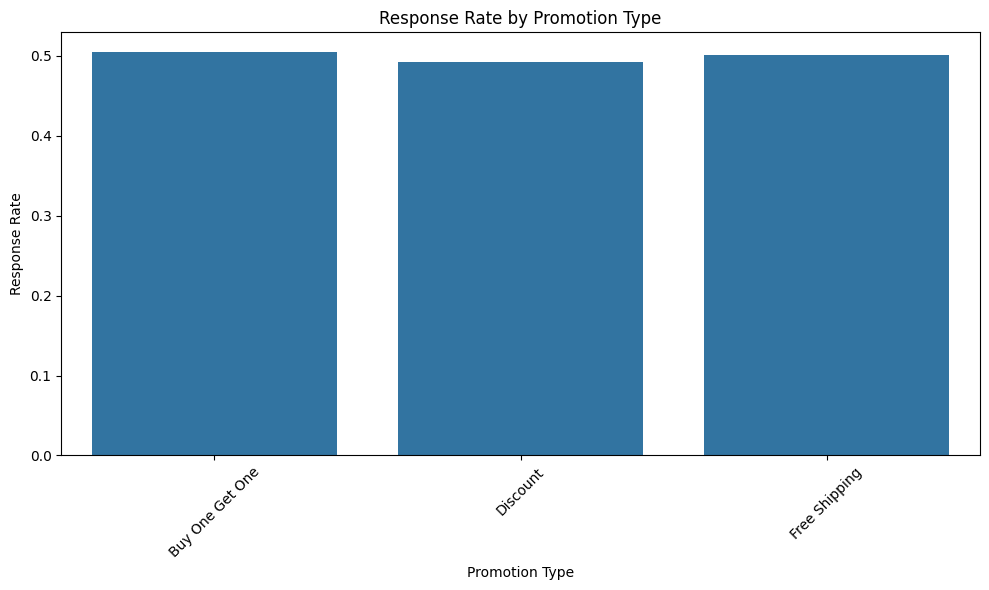

In [159]:
# Calculate response rate for each promotion type
promotion_response = marketing_df.groupby('promotion_type')['response'].value_counts(normalize=True).unstack().fillna(0)
promotion_response['response_rate'] = promotion_response['Yes']

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.barplot(x=promotion_response.index, y=promotion_response['response_rate'])
plt.xlabel('Promotion Type')
plt.ylabel('Response Rate')
plt.title('Response Rate by Promotion Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

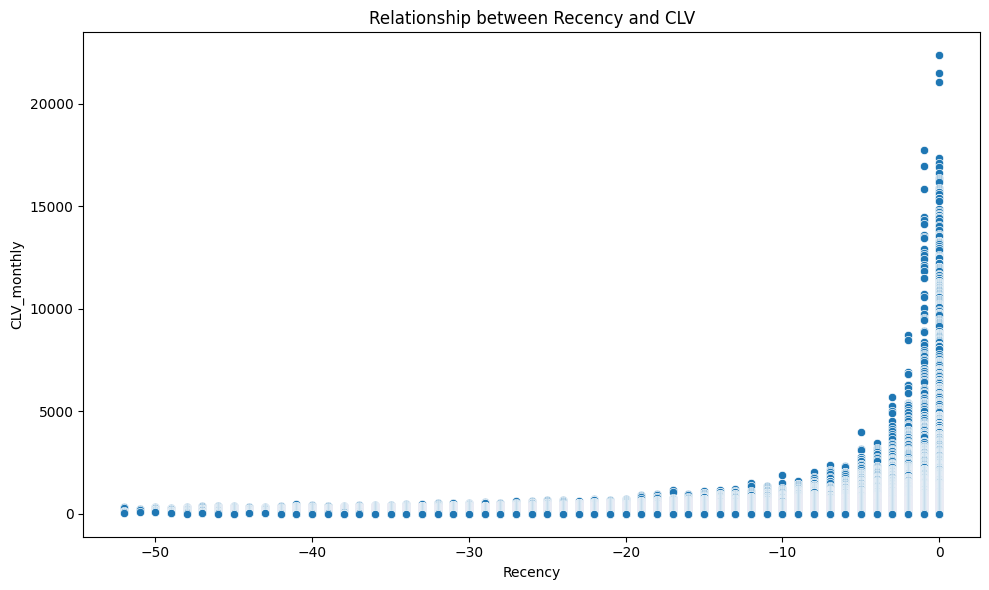

In [57]:
#relationship between recency and clv_monthly
plt.figure(figsize=(10, 6))
sns.scatterplot(x='recency', y='clv_monthly', data=merged_df)
plt.xlabel('Recency')
plt.ylabel('CLV_monthly')
plt.title('Relationship between Recency and CLV')
plt.tight_layout()
plt.show()

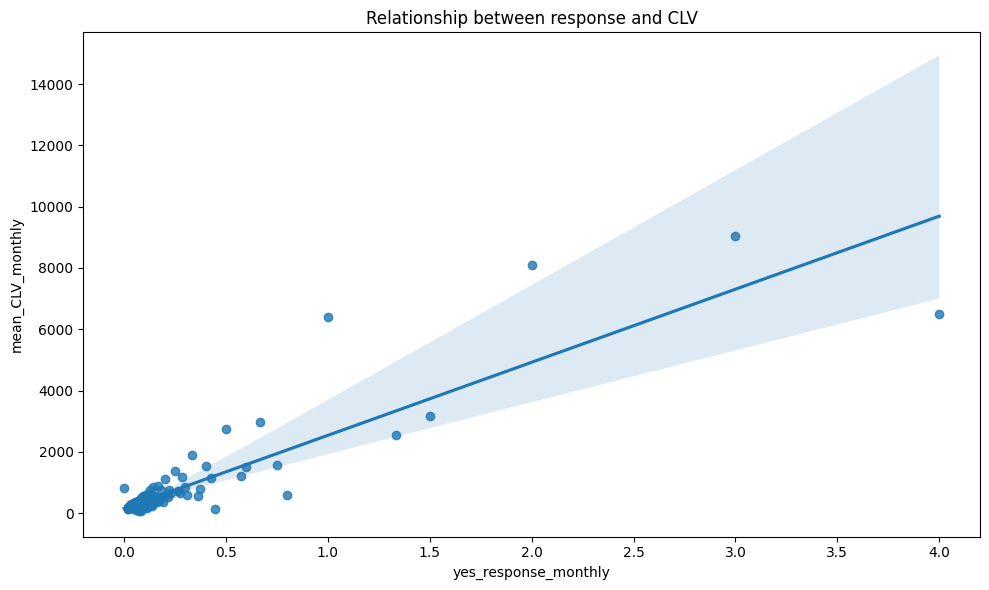

In [54]:
#relationship between response rate and clv_monthly
mean_clv_by_response = merged_df.groupby('yes_response_monthly')['clv_monthly'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.regplot(x=mean_clv_by_response['yes_response_monthly'], y=mean_clv_by_response['clv_monthly'])
plt.xlabel('yes_response_monthly')
plt.ylabel('mean_CLV_monthly')
plt.title('Relationship between response and CLV')
plt.tight_layout()
plt.show()

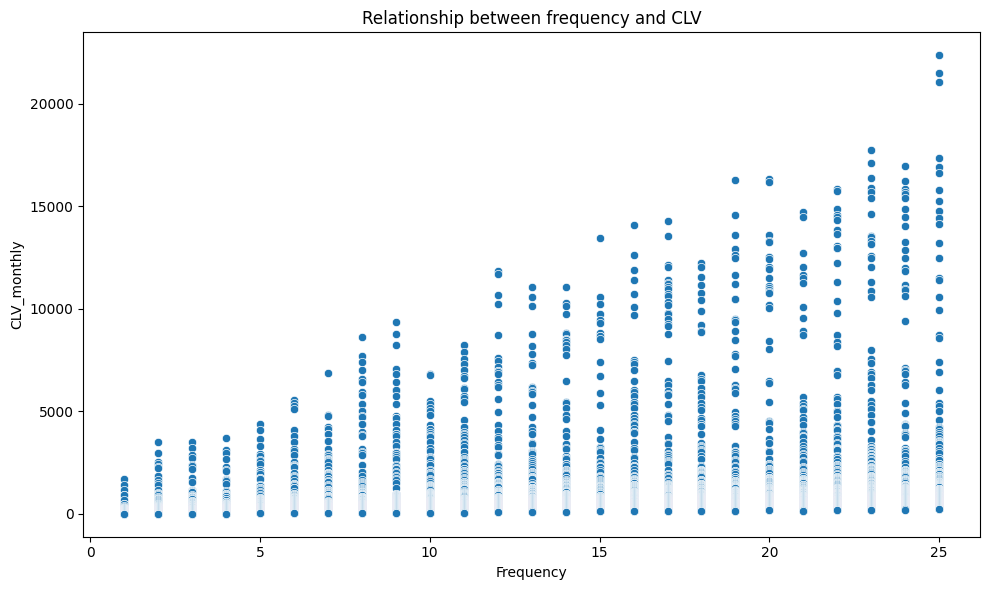

In [61]:
#relationship between frequency and clv_monthly
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='clv_monthly', data=merged_df)
plt.xlabel('Frequency')
plt.ylabel('CLV_monthly')
plt.title('Relationship between frequency and CLV')
plt.tight_layout()
plt.show()

In [65]:
# what kind of product customers like most
# Calculate total transaction amount for each product category
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')
total_transaction_by_product = transactions.groupby('product_category')['transaction_amount'].sum().reset_index()

total_transaction_by_product










,product_category,transaction_amount
0,Clothing,11003319.39
1,Electronics,44498668.65
2,Home Goods,21873641.77


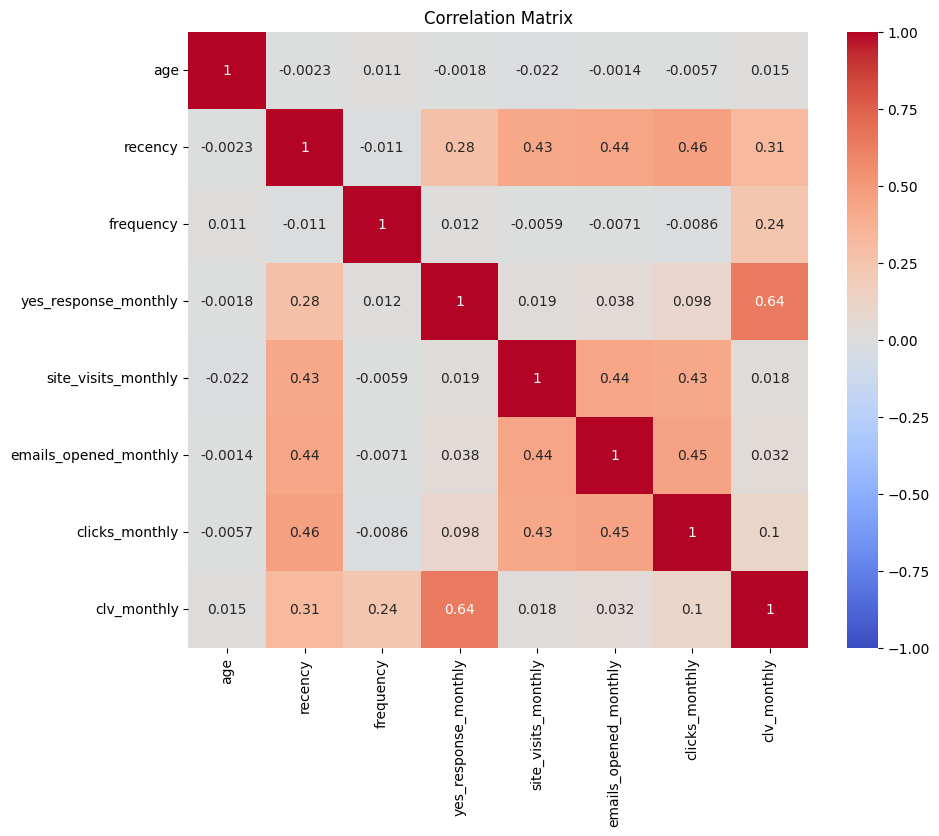

In [58]:
correlation_matrix = merged_df[['age','recency', 'frequency','yes_response_monthly','site_visits_monthly','emails_opened_monthly','clicks_monthly','clv_monthly']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [28]:
## modeling
# Define the x variables and the y variable
y = merged_df['value_label']

# Define the X variables
X = merged_df[['age', 'gender', 'recency', 'frequency', 'yes_response_monthly','clicks_monthly','site_visits_monthly','emails_opened_monthly' ]]
# Create Pipelines and check the F1 socre for each model
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Identify numerical and categorical columns
numerical_cols = ['age', 'recency', 'frequency', 'yes_response_monthly','clicks_monthly','emails_opened_monthly','site_visits_monthly']
categorical_cols = ['gender']

# Define the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)


In [29]:
# Test 3 models with cross validation to see which ones work best for this data
knn = KNeighborsClassifier()
logreg = LogisticRegression()
nb = GaussianNB()
# cross validation to determine in general which model works best for the given problem
knn_scores = cross_val_score(knn, X_train, y_train, scoring='f1', cv=5)
logreg_scores = cross_val_score(logreg, X_train, y_train, scoring='f1', cv=5)
nb_scores = cross_val_score(nb, X_train, y_train, scoring='f1', cv=5)
# High F1 score means better model
print(np.mean(knn_scores))
print(np.mean(logreg_scores))
print(np.mean(nb_scores))

0.7005047311979008
0.7412506186258739
0.5536652216384728


In [30]:
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

In [31]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear', 'saga']
}

# Perform GridSearchCV
logreg = LogisticRegression(max_iter=1000)
grid_search_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# Get the best parameters and the best F1 score
best_params_logreg = grid_search_logreg.best_params_
best_f1_score_logreg = grid_search_logreg.best_score_

print(f'Best parameters for Logistic Regression: {best_params_logreg}')
print(f'Best F1 score for Logistic Regression: {best_f1_score_logreg:.4f}')

d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
175 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Python\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
       

Best parameters for Logistic Regression: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score for Logistic Regression: 0.7517


In [32]:

# Apply the best combination of hyperparameter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
best_logreg = LogisticRegression(**best_params_logreg, max_iter=1000)
best_logreg.fit(X_train, y_train)

# Evaluating the model
# Make predictions on the test set
y_pred_logreg = best_logreg.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
f1_logreg = f1_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, best_logreg.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f'Accuracy: {accuracy_logreg:.4f}')
print(f'Precision: {precision_logreg:.4f}')
print(f'Recall: {recall_logreg:.4f}')
print(f'F1 Score: {f1_logreg:.4f}')
print(f'ROC AUC Score: {roc_auc_logreg:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_logreg))

Accuracy: 0.8885
Precision: 0.8081
Recall: 0.7402
F1 Score: 0.7727
ROC AUC Score: 0.9469

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1488
           1       0.81      0.74      0.77       512

    accuracy                           0.89      2000
   macro avg       0.86      0.84      0.85      2000
weighted avg       0.89      0.89      0.89      2000



<Figure size 1000x600 with 0 Axes>

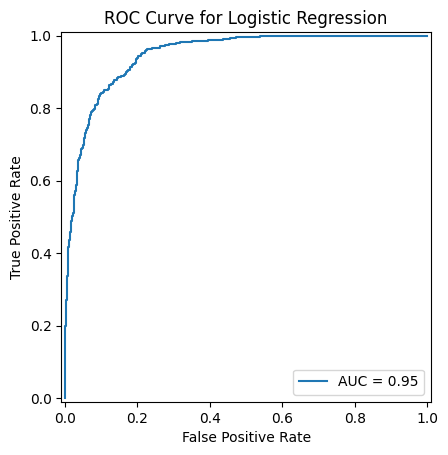

<Figure size 800x600 with 0 Axes>

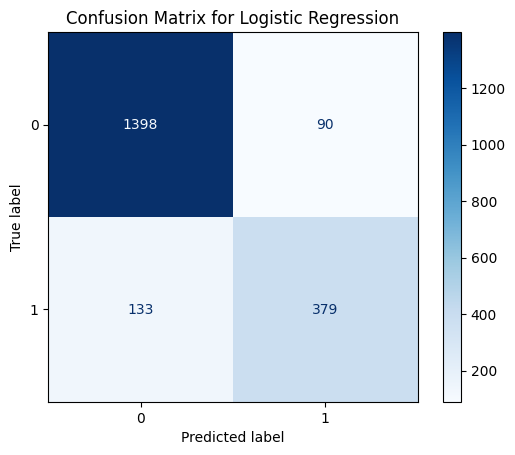

In [33]:
# Generate the ROC curve
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, best_logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10, 6))
roc_display_logreg = RocCurveDisplay(fpr=fpr_logreg, tpr=tpr_logreg, roc_auc=roc_auc_logreg)
roc_display_logreg.plot()
plt.title('ROC Curve for Logistic Regression')
plt.show()

# Generate the confusion matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
cm_display_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg.classes_)
cm_display_logreg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [34]:
# Get Logistic Regression Coefficients and p-values
X_train_sm = sm.add_constant(X_train)
logreg_sm = sm.Logit(y_train, X_train_sm).fit()

coef_pvalues = pd.DataFrame({
    'Feature': ['const'] + list(preprocessor.transformers_[0][2]) + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)),
    'Coefficient': logreg_sm.params,
    'P-Value': logreg_sm.pvalues
})

print(coef_pvalues)

Optimization terminated successfully.
         Current function value: 0.259027
         Iterations 9
                     Feature  Coefficient        P-Value
const                  const   -16.206116  6.339597e-258
x1                       age     0.174607   2.087965e-01
x2                   recency    15.860118  3.550062e-206
x3                 frequency     5.124859  4.616795e-202
x4      yes_response_monthly    18.622444   3.920262e-54
x5            clicks_monthly    -2.845413   4.045150e-28
x6     emails_opened_monthly    -3.584875   6.849002e-36
x7       site_visits_monthly    -2.873249   1.667519e-31
x8               gender_Male    -0.009713   9.041230e-01
x9            gender_Unknown    -0.262659   1.568007e-01


In [44]:
# Try KNN Model
# build our pipeline

# Define the parameter grid for KNN
param_grid = {
'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 25, 25, 45],
'weights': ['uniform', 'distance'],
'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNeighborsClassifier
knn = KNeighborsClassifier()

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best F1 score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print(f'Best parameters: {best_params}')
print(f'Best F1 score: {best_f1_score:.4f}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best F1 score: 0.7379


In [46]:
# Apply the best combination of hyperparameter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)

# Evaluating the model
# Make predictions on the test set
y_pred_knn = best_knn.predict(X_test)

# Evaluate the Logistic Regression model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn= f1_score(y_test, y_pred_knn)
roc_auc_knn = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:, 1])

# Print the evaluation metrics
print(f'Accuracy: {accuracy_knn:.4f}')
print(f'Precision: {precision_knn:.4f}')
print(f'Recall: {recall_knn:.4f}')
print(f'F1 Score: {f1_knn:.4f}')
print(f'ROC AUC Score: {roc_auc_knn:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred_knn))

Accuracy: 0.8820
Precision: 0.8067
Recall: 0.7090
F1 Score: 0.7547
ROC AUC Score: 0.9382

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1488
           1       0.81      0.71      0.75       512

    accuracy                           0.88      2000
   macro avg       0.86      0.83      0.84      2000
weighted avg       0.88      0.88      0.88      2000

